# Plot-Based Book Recommendation system
**Ever finished a book and desperately wished you could find another just like it? The one with the twists that kept you guessing, the moments that made you laugh out loud, or the characters that stole your heart? We all have!**


This project throws out the boring recommendations and dives deeper. We're building a system that analyzes the heart of a story – the plot, the characters, the emotions – to find books that echo the elements you loved. Think of it like a literary matchmaker, connecting you with your next great read.  So, ditch the "been-there-done-that" suggestions and get ready to discover hidden gems that resonate with the stories that hold a special place on your bookelshf!**

# Data importing and cleaning

In [1]:
# Import modules
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
np.random.seed(5)
books_df = pd.read_csv('BooksDataset.csv', sep=",")
print(books_df.head)



<bound method NDFrame.head of                                                     Title  \
0                                           Goat Brothers   
1                                      The Missing Person   
2                       Don't Eat Your Heart Out Cookbook   
3       When Your Corporate Umbrella Begins to Leak: A...   
4         Amy Spangler's Breastfeeding : A Parent's Guide   
...                                                   ...   
103077                        Build 3 Super Serving Carts   
103078                                  My Land of Israel   
103079                  Tongues: To Speak or Not to Speak   
103080   If I'm in charge here why is everybody laughing?   
103081               Your First Puppy (Your First Series)   

                         Authors  \
0               By Colton, Larry   
1             By Grumbach, Doris   
2       By Piscatella, Joseph C.   
3              By Davis, Paul D.   
4               By Spangler, Amy   
...                  

In [2]:
books_df = books_df.drop(columns='Publisher')
books_df = books_df.dropna(subset=['Description'])
print("Number of books loaded: %s " % (len(books_df)))
books_df.head()

Number of books loaded: 70213 


,Title,Authors,Description,Category
7,Journey Through Heartsongs,"By Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,"Poetry , General"
8,In Search of Melancholy Baby,"By Aksyonov, Vassily, Heim, Michael Henry, and...",The Russian author offers an affectionate chro...,"Biography & Autobiography , General"
10,The Dieter's Guide to Weight Loss During Sex,"By Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets"
11,Germs : Biological Weapons and America's Secre...,"By Miller, Judith, Engelberg, Stephen, and Bro...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science"
13,The Good Book: Reading the Bible with Mind and...,"By Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography , General"


# Combining all plot into a single column

In [3]:
books_df["plot"] = books_df[['Authors', 'Description', 'Category']].astype(str).agg(' '.join, axis=1).fillna('')
books_df = books_df.drop(columns=['Authors', 'Description', 'Category'])

books_df.head()

,Title,plot
7,Journey Through Heartsongs,"By Stepanek, Mattie J. T. Collects poems writt..."
8,In Search of Melancholy Baby,"By Aksyonov, Vassily, Heim, Michael Henry, and..."
10,The Dieter's Guide to Weight Loss During Sex,"By Smith, Richard A humor classic, this tongue..."
11,Germs : Biological Weapons and America's Secre...,"By Miller, Judith, Engelberg, Stephen, and Bro..."
13,The Good Book: Reading the Bible with Mind and...,"By Gomes, Peter J. ""The Bible and the social a..."


# Data Preprocessing
* **Using NLP technique- Tokensization and lemmitization**

In [4]:
#Tokenization
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
def preprocess_text(text):
    
    """
      Preprocesses text by:
      1. Tokenizing words
      2. Converting to lowercase
      3. Removing stop words (English by default)
      4. Removing non-alphabetic characters
      5. Lemmatization
      """

    # Tokenizing the texts into words
    tokens = nltk.word_tokenize(text)
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    # Remove stop words (English by default)
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    # Remove non-alphabetic characters 
    tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_text = ' '.join(tokens)
    # Wrap each token in double quotes
    tokens= [f'"{token}"' for token in tokens]
    return processed_text
  

books_df['tokens'] = books_df['plot'].apply(preprocess_text)
books_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,plot,tokens
7,Journey Through Heartsongs,"By Stepanek, Mattie J. T. Collects poems writt...",stepanek mattie j. t. collect poem written ele...
8,In Search of Melancholy Baby,"By Aksyonov, Vassily, Heim, Michael Henry, and...",aksyonov vassily heim michael henry bouis anto...
10,The Dieter's Guide to Weight Loss During Sex,"By Smith, Richard A humor classic, this tongue...",smith richard humor classic tongue-in-cheek di...
11,Germs : Biological Weapons and America's Secre...,"By Miller, Judith, Engelberg, Stephen, and Bro...",miller judith engelberg stephen broad william ...
13,The Good Book: Reading the Bible with Mind and...,"By Gomes, Peter J. ""The Bible and the social a...",gomes peter j bible social moral consequence d...


# Model Selection
**Feature Selection- TF-IDF: This captures the importance of a word based on its frequency in a document and its rarity across the corpus.**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
books_df['tokens'] = books_df['plot'].apply(preprocess_text)
# Creating TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(books_df['tokens'])
print(tfidf_matrix.shape)

(70213, 120340)


# KMeans Clustering

* If you have user-book interaction data (ratings, purchases, etc.), you could use K-means to cluster users based on their preferences. Then, for a new user, recommend books popular among users in the same cluster.

In [7]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
books_df["cluster"] = clusters
books_df['cluster'].value_counts() 

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    22788
1    20237
4    15806
3     8548
2     2834
Name: count, dtype: int64

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
# Example usage: Find similar books based on a user query
user_query = "a thrilling mystery novel with a detective investigating a murder."
user_query_processed = preprocess_text(user_query)
user_query_vector = vectorizer.transform([user_query_processed])

# Calculate cosine similarity between user query and all books
cosine_similarities = cosine_similarity(user_query_vector, tfidf_matrix)

# Find the top 5 most similar books (based on cosine similarity)
top_5_indices = cosine_similarities.argsort()[0][-5:] 
print("Recommended Books:")
for idx in top_5_indices:
    print(books_df.iloc[idx]['Title']) 


Recommended Books:
Bird In A Cage
Mystery
Poison: An 87th Precinct Novel
Ghosts
Police Procedurals (Academy Mystery Novellas)


# NearestNeighbors
* It identifies the nearest neighbors (most similar books) based on the TF-IDF vector of the user's query.
* It doesn't require specifying the number of clusters upfront (unlike K-means).

In [11]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5)  # Find 5 nearest neighbors
knn.fit(tfidf_matrix)
distances, indices = knn.kneighbors(user_query_vector.reshape(1, -1))
recommended_books = [books_df.iloc[idx]['Title'] for idx in indices.flatten()]

print("Recommended Books:")
for book_title in recommended_books:
  print(book_title)


Recommended Books:
Police Procedurals (Academy Mystery Novellas)
Ghosts
Poison: An 87th Precinct Novel
Mystery
Bird In A Cage


# Data Visualization

In [14]:
pip install wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   ----- --------------------------------- 41.0/300.2 kB 487.6 kB/s eta 0:00:01
   ---------------------------------- ----- 256.0/300.2 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


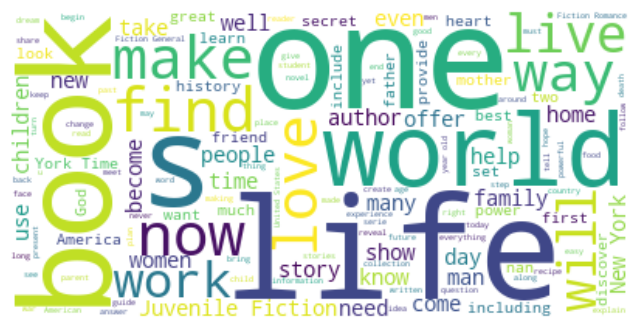

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

def plot_wordcloud(text):
  wordcloud = WordCloud(background_color="white", max_words=200)
  wordcloud.generate(text)
  plt.figure(figsize=(8, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

# Combine all book plot into a single string
all_text = ' '.join(books_df['plot'])

plot_wordcloud(all_text)


As we can see the above wordCloud, the words that are in large fonts represents more frequently appeared in plot. 
Words like Book, Life, One etc are more frequent and words like Story, Show, Heart etc. appears less frequent.

## TruncatedSVD for dimentional reduction of sparse matrice or TF-IDF matrice

In [19]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=0)
svd.fit(tfidf_matrix)
# Transform the data to the lower-dimensional space
reduced_data = svd.transform(tfidf_matrix)


## PCA for Dimentional Reduction after performing Truncated SVD

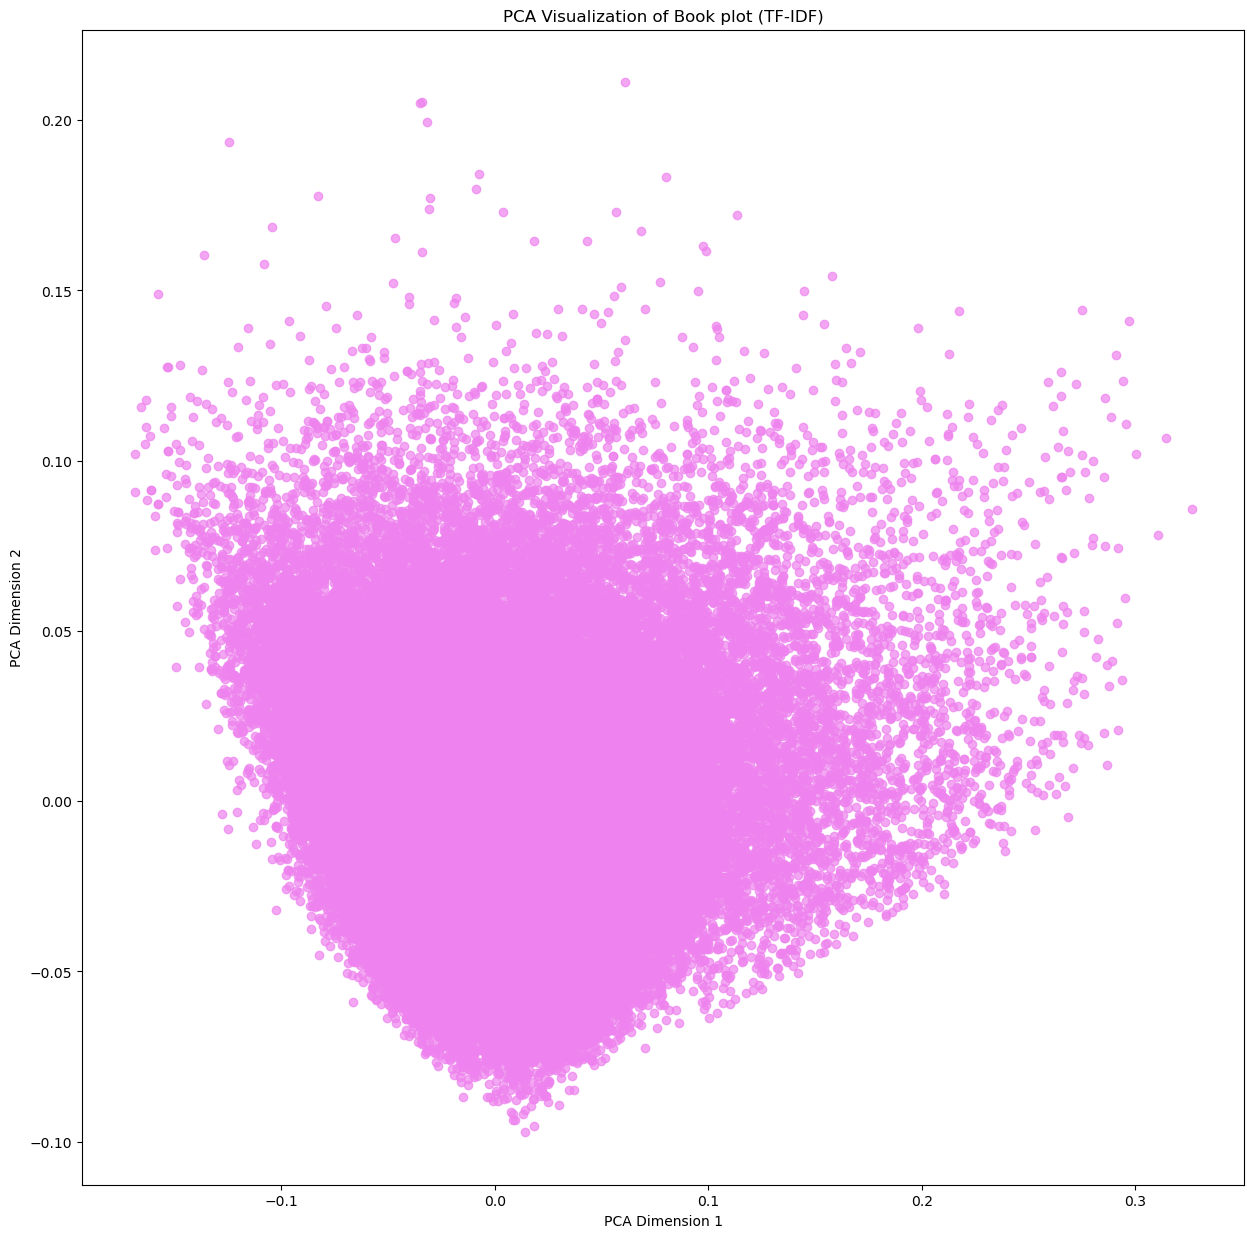

In [25]:
from sklearn.decomposition import PCA

def plot_pca_scatter(reduced_data):
    pca = PCA(n_components=2, random_state=0)
  pca_data = pca.fit_transform(reduced_data)

  # Scatter plot the transformed data (adjust colors and labels as needed)
  plt.figure(figsize=(15, 15))
  plt.scatter(pca_data[:, 0], pca_data[:, 1], c='violet', alpha=0.7)
  plt.xlabel('PCA Dimension 1')
  plt.ylabel('PCA Dimension 2')
  plt.title('PCA Visualization of Book plot (TF-IDF)')
  plt.show()

# Assuming you have the TF-IDF matrix (tfidf_matrix)
plot_pca_scatter(reduced_data)
